In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,RepeatVector,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [7]:
data = pd.read_csv('CNA.csv')

In [8]:
data

,ticker,date,open,high,low,close
0,CNA,3/17/1980,0.000,0.760,0.730,0.73
1,CNA,3/18/1980,0.000,0.730,0.710,0.72
2,CNA,3/19/1980,0.000,0.740,0.720,0.72
3,CNA,3/20/1980,0.000,0.730,0.720,0.72
4,CNA,3/21/1980,0.000,0.720,0.690,0.69
...,...,...,...,...,...,...
10919,CNA,7/10/2023,185.910,191.090,185.770,191.05
10920,CNA,7/11/2023,191.660,192.070,187.598,190.95
10921,CNA,7/12/2023,193.410,196.050,192.575,195.40
10922,CNA,7/13/2023,196.680,199.440,195.910,198.27


In [9]:
data = data.filter(['close'])


In [10]:
# Lấy 100 dòng cuối cùng của df
data = data.tail(1000)
data

,close
9924,122.18
9925,121.80
9926,121.21
9927,120.96
9928,117.46
...,...
10919,191.05
10920,190.95
10921,195.40
10922,198.27


In [11]:
#Tiền xử lý
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
dataScale = scaler.fit_transform(data.values.reshape(-1,1))

In [12]:
# Hàm tính giá trị alpha tối ưu
def optimum_alpha(X):
    X_max = np.max(X)
    X_min = np.min(X)
    n = len(X)
    return ((X_max - X_min) - (1/n) * np.sum(X)) / (X_max - X_min)


In [13]:
def smoothed(X, alpha):
    S = np.zeros_like(X)
    S[0] = X[0]
    for i in range(1, len(X)):
        S[i] = S[i-1] + alpha*(X[i] - S[i-1])
    return S

In [14]:
alpha = optimum_alpha(dataScale)


In [15]:
S = smoothed(dataScale, alpha)
print("Giá trị alpha tối ưu:", alpha)
print("Chuỗi ban đầu:", dataScale)
print("Chuỗi đã được làm mịn:", S)


Giá trị alpha tối ưu: 0.4349331265081007
Chuỗi ban đầu: [[0.34427784]
 [0.3410031 ]
 [0.33591865]
 [0.33376422]
 [0.30360221]
 [0.27774905]
 [0.26240951]
 [0.21889004]
 [0.23310927]
 [0.23776284]
 [0.25939331]
 [0.24500172]
 [0.2303516 ]
 [0.26533954]
 [0.24198552]
 [0.22595657]
 [0.24379524]
 [0.24939676]
 [0.24181317]
 [0.22716305]
 [0.22750776]
 [0.18907273]
 [0.20510169]
 [0.21389176]
 [0.22233713]
 [0.23086867]
 [0.23784902]
 [0.20811789]
 [0.23233368]
 [0.26533954]
 [0.26232334]
 [0.26404688]
 [0.27361255]
 [0.28274733]
 [0.29283006]
 [0.29550155]
 [0.28464323]
 [0.28481558]
 [0.29584626]
 [0.28998621]
 [0.28524647]
 [0.27628404]
 [0.24758704]
 [0.26240951]
 [0.26637366]
 [0.24827646]
 [0.25422268]
 [0.23741813]
 [0.23043778]
 [0.24681144]
 [0.26542572]
 [0.24655291]
 [0.20596346]
 [0.22268183]
 [0.22587039]
 [0.24982765]
 [0.24224405]
 [0.26766632]
 [0.24439848]
 [0.23931403]
 [0.23483282]
 [0.2488797 ]
 [0.24689762]
 [0.20113754]
 [0.19898311]
 [0.21199586]
 [0.2292313 ]
 [0.22

D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Smooth')

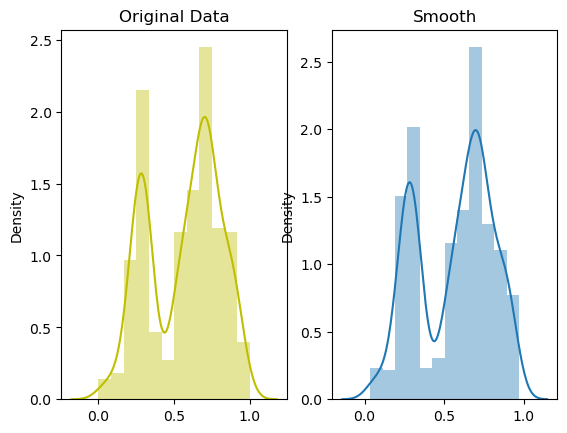

In [16]:
import seaborn as sns

fig, ax=plt.subplots(1,2)
sns.distplot(dataScale, ax=ax[0], color='y')
ax[0].set_title("Original Data")


sns.distplot(S,ax=ax[1])
ax[1].set_title("Smooth")


In [17]:
#Chia dữ liệu thành train test
data = pd.DataFrame(S)

#dataScale = data
train_percent = 0.8
train_size = int(len(data) * train_percent)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [18]:
#Chuẩn bị dữ liệu để đưa vào mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
          
       
        startWindow += stepWindow
    return np.array(X), np.array(y)


size_window = 14
size_predict = 1
stepWindow = 1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

In [19]:
start_time = time.time()

In [20]:

# Tạo mô hình CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(size_window, 1)))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
for i in range(4):
    model.add(Dense(units=100, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

# Compile mô hình với Adam optimizer và Mean Squared Error loss
model.compile(loss='mse', optimizer='adam')


In [21]:
history = model.fit(X_train, y_train, epochs=8000, batch_size=8)

Epoch 1/8000
99/99 [==============================] - 2s 2ms/step - loss: 0.0731
Epoch 2/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 3/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 4/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 5/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 6/8000
99/99 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 7/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 8/8000
99/99 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 9/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 10/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 11/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 12/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 13/8000
99/99 [====

99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 102/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 103/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 104/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 105/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 106/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 107/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 108/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 109/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 110/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 111/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 112/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 113/8000
99/9

99/99 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 200/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 201/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 202/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 203/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 204/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 205/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 206/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 207/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 208/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 209/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 210/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 211/8000
99/9

99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 298/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 299/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3653e-04
Epoch 300/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 301/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 302/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 303/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 304/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 305/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5897e-04
Epoch 306/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 307/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 308/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 309/8

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 396/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 397/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9712e-04
Epoch 398/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 399/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 400/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 401/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 402/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 403/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 404/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 405/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 406/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5829e-04
Epoch 407/8

99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 494/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 495/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 496/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 497/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 498/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 499/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7091e-04
Epoch 500/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6587e-04
Epoch 501/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 502/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 503/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 504/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 505/8

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 592/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 593/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 594/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 595/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 596/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 597/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 598/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7470e-04
Epoch 599/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 600/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 601/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5122e-04
Epoch 602/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 603/8

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 689/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 690/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5494e-04
Epoch 691/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 692/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8050e-04
Epoch 693/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8140e-04
Epoch 694/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 695/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 696/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 697/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 698/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 699/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5302e-04
Epo

99/99 [==============================] - 0s 1ms/step - loss: 9.6619e-04
Epoch 786/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 787/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 788/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 789/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 790/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3003e-04
Epoch 791/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 792/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 793/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 794/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 795/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7501e-04
Epoch 796/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 7

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 883/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 884/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 885/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 886/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6897e-04
Epoch 887/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 888/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6050e-04
Epoch 889/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 890/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9555e-04
Epoch 891/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 892/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 893/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 8

99/99 [==============================] - 0s 1ms/step - loss: 9.4478e-04
Epoch 980/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 981/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7076e-04
Epoch 982/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9804e-04
Epoch 983/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4387e-04
Epoch 984/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1548e-04
Epoch 985/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 986/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 987/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2242e-04
Epoch 988/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 989/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 990/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.

99/99 [==============================] - 0s 1ms/step - loss: 9.9548e-04
Epoch 1076/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2891e-04
Epoch 1077/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1078/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1079/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1080/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5926e-04
Epoch 1081/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1082/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1083/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1084/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9984e-04
Epoch 1085/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8512e-04
Epoch 1086/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1171/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1172/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1173/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 1174/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4793e-04
Epoch 1175/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9295e-04
Epoch 1176/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1177/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5515e-04
Epoch 1178/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7196e-04
Epoch 1179/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8853e-04
Epoch 1180/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1181/8000
99/99 [==============================] - 0s 1ms/step - l

Epoch 1266/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8988e-04
Epoch 1267/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1268/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1269/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1270/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1271/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1272/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1273/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5419e-04
Epoch 1274/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1275/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8700e-04
Epoch 1276/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1277/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.9130e-04
Epoch 1363/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1364/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1365/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1366/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1367/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1368/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1369/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1370/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1371/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5638e-04
Epoch 1372/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1373/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010


99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1458/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4318e-04
Epoch 1459/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1460/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1461/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1462/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7383e-04
Epoch 1463/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8809e-04
Epoch 1464/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9174e-04
Epoch 1465/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9190e-04
Epoch 1466/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2069e-04
Epoch 1467/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9653e-04
Epoch 1468/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.6099e-04
Epoch 1553/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6353e-04
Epoch 1554/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5077e-04
Epoch 1555/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1556/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1557/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1558/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1559/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3575e-04
Epoch 1560/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2456e-04
Epoch 1561/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1562/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1563/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.8862e-04
Epoch 1648/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1649/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1650/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8161e-04
Epoch 1651/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5834e-04
Epoch 1652/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1653/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5813e-04
Epoch 1654/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7641e-04
Epoch 1655/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9036e-04
Epoch 1656/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1657/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1658/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 9.6179e-04
Epoch 1743/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5663e-04
Epoch 1744/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1745/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1746/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9187e-04
Epoch 1747/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1748/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1749/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9103e-04
Epoch 1750/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1751/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1752/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1753/8000
99/99 [==============================] - 0s 1ms/step - loss:

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1838/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9044e-04
Epoch 1839/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7696e-04
Epoch 1840/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1841/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1842/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1843/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1844/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3008e-04
Epoch 1845/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1846/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1847/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8675e-04
Epoch 1848/8000
99/99 [==============================] - 0s 1ms/step - loss:

99/99 [==============================] - 0s 1ms/step - loss: 9.8265e-04
Epoch 1932/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6991e-04
Epoch 1933/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1934/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1935/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1936/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1937/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1938/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4945e-04
Epoch 1939/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 1940/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1941/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1942/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2027/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4629e-04
Epoch 2028/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2029/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2030/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5984e-04
Epoch 2031/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2032/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8624e-04
Epoch 2033/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2034/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0571e-04
Epoch 2035/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7804e-04
Epoch 2036/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2037/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.1080e-04
Epoch 2122/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2123/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7851e-04
Epoch 2124/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2125/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7856e-04
Epoch 2126/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7806e-04
Epoch 2127/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2128/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2129/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2130/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2131/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9092e-04
Epoch 2132/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2217/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2218/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2219/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3598e-04
Epoch 2220/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1015e-04
Epoch 2221/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2549e-04
Epoch 2222/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2223/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 2224/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2225/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7850e-04
Epoch 2226/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2227/8000
99/99 [==============================] - 0s 1ms/step - loss:

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2312/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3165e-04
Epoch 2313/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2314/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2905e-04
Epoch 2315/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3519e-04
Epoch 2316/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7191e-04
Epoch 2317/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2318/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2319/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2320/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8694e-04
Epoch 2321/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2322/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.2389e-04
Epoch 2407/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5198e-04
Epoch 2408/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 2409/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2410/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9605e-04
Epoch 2411/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5656e-04
Epoch 2412/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1243e-04
Epoch 2413/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9138e-04
Epoch 2414/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2819e-04
Epoch 2415/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2416/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9606e-04
Epoch 2417/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2501/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2502/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0537e-04
Epoch 2503/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7174e-04
Epoch 2504/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5904e-04
Epoch 2505/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9225e-04
Epoch 2506/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2507/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4208e-04
Epoch 2508/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5340e-04
Epoch 2509/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5226e-04
Epoch 2510/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6493e-04
Epoch 2511/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2595/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2596/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2597/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8236e-04
Epoch 2598/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4196e-04
Epoch 2599/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2600/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5098e-04
Epoch 2601/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8780e-04
Epoch 2602/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2603/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9060e-04
Epoch 2604/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2411e-04
Epoch 2605/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2689/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 2690/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6296e-04
Epoch 2691/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3975e-04
Epoch 2692/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2693/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4133e-04
Epoch 2694/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 2695/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3222e-04
Epoch 2696/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3209e-04
Epoch 2697/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7847e-04
Epoch 2698/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2699/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 9.0799e-04
Epoch 2783/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5012e-04
Epoch 2784/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4853e-04
Epoch 2785/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3527e-04
Epoch 2786/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2020e-04
Epoch 2787/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2788/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8607e-04
Epoch 2789/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5141e-04
Epoch 2790/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2791/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7564e-04
Epoch 2792/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6884e-04
Epoch 2793/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2877/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2878/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5871e-04
Epoch 2879/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2880/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2881/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2882/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2883/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6912e-04
Epoch 2884/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5894e-04
Epoch 2885/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9254e-04
Epoch 2886/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8272e-04
Epoch 2887/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.2182e-04
Epoch 2972/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2973/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6981e-04
Epoch 2974/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2975/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7905e-04
Epoch 2976/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2977/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8451e-04
Epoch 2978/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9212e-04
Epoch 2979/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7069e-04
Epoch 2980/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1142e-04
Epoch 2981/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2982/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3067/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3068/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4538e-04
Epoch 3069/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3070/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3071/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8624e-04
Epoch 3072/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6803e-04
Epoch 3073/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9423e-04
Epoch 3074/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7498e-04
Epoch 3075/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3076/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8712e-04
Epoch 3077/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 8.6805e-04
Epoch 3162/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9199e-04
Epoch 3163/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3164/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3165/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3166/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1762e-04
Epoch 3167/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3168/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3169/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3170/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3171/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8421e-04
Epoch 3172/8000
99/99 [==============================] - 0s 1ms/step - loss:

99/99 [==============================] - 0s 1ms/step - loss: 9.4349e-04
Epoch 3257/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4275e-04
Epoch 3258/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3259/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9709e-04
Epoch 3260/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9415e-04
Epoch 3261/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 3262/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3263/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 3264/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3265/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3266/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6040e-04
Epoch 3267/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3352/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3353/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5044e-04
Epoch 3354/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6195e-04
Epoch 3355/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4076e-04
Epoch 3356/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 3357/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8956e-04
Epoch 3358/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6508e-04
Epoch 3359/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3360/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7720e-04
Epoch 3361/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3362/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 9.5547e-04
Epoch 3446/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7376e-04
Epoch 3447/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3448/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3449/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6547e-04
Epoch 3450/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3192e-04
Epoch 3451/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4780e-04
Epoch 3452/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3453/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1202e-04
Epoch 3454/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5442e-04
Epoch 3455/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3456/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 3540/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4957e-04
Epoch 3541/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1328e-04
Epoch 3542/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3024e-04
Epoch 3543/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 3544/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3545/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7419e-04
Epoch 3546/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3547/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7472e-04
Epoch 3548/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3898e-04
Epoch 3549/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2941e-04
Epoch 3550/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.6829e-04
Epoch 3634/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3635/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8454e-04
Epoch 3636/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8795e-04
Epoch 3637/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7794e-04
Epoch 3638/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8125e-04
Epoch 3639/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3640/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9229e-04
Epoch 3641/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8004e-04
Epoch 3642/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3980e-04
Epoch 3643/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3644/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3728/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.1922e-04
Epoch 3729/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3730/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5492e-04
Epoch 3731/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7658e-04
Epoch 3732/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3429e-04
Epoch 3733/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1831e-04
Epoch 3734/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3735/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7248e-04
Epoch 3736/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1205e-04
Epoch 3737/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7326e-04
Epoch 3738/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3822/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5417e-04
Epoch 3823/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7752e-04
Epoch 3824/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3825/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3826/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3827/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4345e-04
Epoch 3828/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3829/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3830/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5436e-04
Epoch 3831/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8497e-04
Epoch 3832/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.5704e-04
Epoch 3916/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3917/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7133e-04
Epoch 3918/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9454e-04
Epoch 3919/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7941e-04
Epoch 3920/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 3921/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2140e-04
Epoch 3922/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 3923/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8742e-04
Epoch 3924/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3925/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 3926/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4010/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3385e-04
Epoch 4011/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3741e-04
Epoch 4012/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8340e-04
Epoch 4013/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9536e-04
Epoch 4014/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7223e-04
Epoch 4015/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2617e-04
Epoch 4016/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7795e-04
Epoch 4017/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5653e-04
Epoch 4018/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4019/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4020/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 9.6010e-04
Epoch 4104/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0747e-04
Epoch 4105/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4106/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4107/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6335e-04
Epoch 4108/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4109/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4420e-04
Epoch 4110/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1515e-04
Epoch 4111/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4112/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4113/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7960e-04
Epoch 4114/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 9.7189e-04
Epoch 4198/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4340e-04
Epoch 4199/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4200/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4201/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5229e-04
Epoch 4202/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 4203/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5409e-04
Epoch 4204/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4205/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4206/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2127e-04
Epoch 4207/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9786e-04
Epoch 4208/8000
99/99 [==============================] - 0s 1ms/step

Epoch 4292/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9149e-04
Epoch 4293/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7086e-04
Epoch 4294/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6219e-04
Epoch 4295/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5855e-04
Epoch 4296/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7538e-04
Epoch 4297/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8479e-04
Epoch 4298/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4299/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8620e-04
Epoch 4300/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4301/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7679e-04
Epoch 4302/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3039e-04
Epoch 4303/8000
99/99 [=================

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4387/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4388/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0014e-04
Epoch 4389/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4390/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9228e-04
Epoch 4391/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4392/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6223e-04
Epoch 4393/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5763e-04
Epoch 4394/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7403e-04
Epoch 4395/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4138e-04
Epoch 4396/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5741e-04
Epoch 4397/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.3640e-04
Epoch 4481/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7749e-04
Epoch 4482/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9780e-04
Epoch 4483/8000
99/99 [==============================] - 0s 2ms/step - loss: 9.4737e-04
Epoch 4484/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6568e-04
Epoch 4485/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4477e-04
Epoch 4486/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0922e-04
Epoch 4487/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7581e-04
Epoch 4488/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7747e-04
Epoch 4489/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4081e-04
Epoch 4490/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4083e-04
Epoch 4491/8000
99/99 [=========================

99/99 [==============================] - 0s 1ms/step - loss: 8.6581e-04
Epoch 4575/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3023e-04
Epoch 4576/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9993e-04
Epoch 4577/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5671e-04
Epoch 4578/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4579/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4379e-04
Epoch 4580/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3319e-04
Epoch 4581/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1323e-04
Epoch 4582/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8728e-04
Epoch 4583/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4605e-04
Epoch 4584/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8279e-04
Epoch 4585/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 8.9474e-04
Epoch 4669/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5042e-04
Epoch 4670/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4671/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4672/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9663e-04
Epoch 4673/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9170e-04
Epoch 4674/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7473e-04
Epoch 4675/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4425e-04
Epoch 4676/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2455e-04
Epoch 4677/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2119e-04
Epoch 4678/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4679/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4763/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0443e-04
Epoch 4764/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0058e-04
Epoch 4765/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9164e-04
Epoch 4766/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.3465e-04
Epoch 4767/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4658e-04
Epoch 4768/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4769/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3452e-04
Epoch 4770/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8108e-04
Epoch 4771/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4772/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4773/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4857/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4858/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7188e-04
Epoch 4859/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1555e-04
Epoch 4860/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8521e-04
Epoch 4861/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4862/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4863/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4864/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4865/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4020e-04
Epoch 4866/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6959e-04
Epoch 4867/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.6310e-04
Epoch 4951/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4952/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7657e-04
Epoch 4953/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4004e-04
Epoch 4954/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2242e-04
Epoch 4955/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.1943e-04
Epoch 4956/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4957/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0790e-04
Epoch 4958/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8127e-04
Epoch 4959/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3694e-04
Epoch 4960/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7151e-04
Epoch 4961/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.7462e-04
Epoch 5045/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8166e-04
Epoch 5046/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3965e-04
Epoch 5047/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8499e-04
Epoch 5048/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6942e-04
Epoch 5049/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9258e-04
Epoch 5050/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5051/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8314e-04
Epoch 5052/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5053/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5054/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8801e-04
Epoch 5055/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 9.7700e-04
Epoch 5139/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 5140/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7859e-04
Epoch 5141/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8410e-04
Epoch 5142/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5143/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5144/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8138e-04
Epoch 5145/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5833e-04
Epoch 5146/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6331e-04
Epoch 5147/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7741e-04
Epoch 5148/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5149/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.3197e-04
Epoch 5233/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5043e-04
Epoch 5234/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9832e-04
Epoch 5235/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4937e-04
Epoch 5236/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2576e-04
Epoch 5237/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4302e-04
Epoch 5238/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2953e-04
Epoch 5239/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5869e-04
Epoch 5240/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5461e-04
Epoch 5241/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5242/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4943e-04
Epoch 5243/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 9.9685e-04
Epoch 5327/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6102e-04
Epoch 5328/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5998e-04
Epoch 5329/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1314e-04
Epoch 5330/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4288e-04
Epoch 5331/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4970e-04
Epoch 5332/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8318e-04
Epoch 5333/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3949e-04
Epoch 5334/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9513e-04
Epoch 5335/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8399e-04
Epoch 5336/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5337/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5421/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8294e-04
Epoch 5422/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.0424e-04
Epoch 5423/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0445e-04
Epoch 5424/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1308e-04
Epoch 5425/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2591e-04
Epoch 5426/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5427/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8436e-04
Epoch 5428/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5059e-04
Epoch 5429/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9713e-04
Epoch 5430/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3382e-04
Epoch 5431/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.9842e-04
Epoch 5515/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5516/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0959e-04
Epoch 5517/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5518/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9677e-04
Epoch 5519/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5595e-04
Epoch 5520/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5521/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6282e-04
Epoch 5522/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2020e-04
Epoch 5523/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2372e-04
Epoch 5524/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5525/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5609/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5610/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5611/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2014e-04
Epoch 5612/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6983e-04
Epoch 5613/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5614/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9973e-04
Epoch 5615/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5525e-04
Epoch 5616/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8025e-04
Epoch 5617/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5618/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9798e-04
Epoch 5619/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5703/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6882e-04
Epoch 5704/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7863e-04
Epoch 5705/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5706/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4256e-04
Epoch 5707/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8441e-04
Epoch 5708/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7434e-04
Epoch 5709/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9573e-04
Epoch 5710/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5711/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7921e-04
Epoch 5712/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4615e-04
Epoch 5713/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5797/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2955e-04
Epoch 5798/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6393e-04
Epoch 5799/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7727e-04
Epoch 5800/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8569e-04
Epoch 5801/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1063e-04
Epoch 5802/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1132e-04
Epoch 5803/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4882e-04
Epoch 5804/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8684e-04
Epoch 5805/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6252e-04
Epoch 5806/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3817e-04
Epoch 5807/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 9.7015e-04
Epoch 5891/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7359e-04
Epoch 5892/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2690e-04
Epoch 5893/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.3763e-04
Epoch 5894/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7488e-04
Epoch 5895/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5896/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7790e-04
Epoch 5897/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1556e-04
Epoch 5898/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5899/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9070e-04
Epoch 5900/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6761e-04
Epoch 5901/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 8.4001e-04
Epoch 5985/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5986/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5987/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5988/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9503e-04
Epoch 5989/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5990/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5556e-04
Epoch 5991/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1400e-04
Epoch 5992/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5993/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 5994/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.0480e-04
Epoch 5995/8000
99/99 [==============================] - 0s 1ms/step - l

99/99 [==============================] - 0s 1ms/step - loss: 9.9199e-04
Epoch 6079/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9779e-04
Epoch 6080/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6081/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9022e-04
Epoch 6082/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7342e-04
Epoch 6083/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6167e-04
Epoch 6084/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6085/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6216e-04
Epoch 6086/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5914e-04
Epoch 6087/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3129e-04
Epoch 6088/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8150e-04
Epoch 6089/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.9978e-04
Epoch 6173/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9692e-04
Epoch 6174/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6175/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7946e-04
Epoch 6176/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1120e-04
Epoch 6177/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9621e-04
Epoch 6178/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4255e-04
Epoch 6179/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6549e-04
Epoch 6180/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6688e-04
Epoch 6181/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1396e-04
Epoch 6182/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6839e-04
Epoch 6183/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 9.3647e-04
Epoch 6267/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.4770e-04
Epoch 6268/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6041e-04
Epoch 6269/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.3250e-04
Epoch 6270/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6271/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3278e-04
Epoch 6272/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6273/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3780e-04
Epoch 6274/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5667e-04
Epoch 6275/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9268e-04
Epoch 6276/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6277/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 6361/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7810e-04
Epoch 6362/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4353e-04
Epoch 6363/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6364/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2272e-04
Epoch 6365/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6366/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9882e-04
Epoch 6367/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0493e-04
Epoch 6368/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7907e-04
Epoch 6369/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6934e-04
Epoch 6370/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6371/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.3314e-04
Epoch 6455/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9181e-04
Epoch 6456/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1839e-04
Epoch 6457/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8978e-04
Epoch 6458/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6854e-04
Epoch 6459/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8980e-04
Epoch 6460/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6849e-04
Epoch 6461/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9284e-04
Epoch 6462/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0953e-04
Epoch 6463/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6464/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4257e-04
Epoch 6465/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6549/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3818e-04
Epoch 6550/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2470e-04
Epoch 6551/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6078e-04
Epoch 6552/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0737e-04
Epoch 6553/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6526e-04
Epoch 6554/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6731e-04
Epoch 6555/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0371e-04
Epoch 6556/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4586e-04
Epoch 6557/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6558/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6559/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 9.4635e-04
Epoch 6643/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3081e-04
Epoch 6644/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4710e-04
Epoch 6645/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9907e-04
Epoch 6646/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.1992e-04
Epoch 6647/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2643e-04
Epoch 6648/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6649/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8596e-04
Epoch 6650/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9699e-04
Epoch 6651/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3726e-04
Epoch 6652/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0079e-04
Epoch 6653/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 9.2970e-04
Epoch 6737/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9079e-04
Epoch 6738/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6739/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4243e-04
Epoch 6740/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.1304e-04
Epoch 6741/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3599e-04
Epoch 6742/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6321e-04
Epoch 6743/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6744/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8305e-04
Epoch 6745/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6746/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6747/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.3861e-04
Epoch 6831/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9884e-04
Epoch 6832/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6102e-04
Epoch 6833/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2048e-04
Epoch 6834/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6835/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9860e-04
Epoch 6836/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6615e-04
Epoch 6837/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6838/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8353e-04
Epoch 6839/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7932e-04
Epoch 6840/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 6841/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 9.9199e-04
Epoch 6925/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9667e-04
Epoch 6926/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9373e-04
Epoch 6927/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6928/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9361e-04
Epoch 6929/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6144e-04
Epoch 6930/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6931/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6932/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9386e-04
Epoch 6933/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5409e-04
Epoch 6934/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2161e-04
Epoch 6935/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 9.4710e-04
Epoch 7018/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8956e-04
Epoch 7019/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4549e-04
Epoch 7020/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0869e-04
Epoch 7021/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7807e-04
Epoch 7022/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6402e-04
Epoch 7023/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7024/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7025/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2995e-04
Epoch 7026/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7064e-04
Epoch 7027/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6079e-04
Epoch 7028/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 8.6124e-04
Epoch 7112/8000
99/99 [==============================] - 0s 1ms/step - loss: 7.9843e-04
Epoch 7113/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6920e-04
Epoch 7114/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7115/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4296e-04
Epoch 7116/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7117/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7118/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5789e-04
Epoch 7119/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0778e-04
Epoch 7120/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0237e-04
Epoch 7121/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2138e-04
Epoch 7122/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7206/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7207/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8623e-04
Epoch 7208/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3839e-04
Epoch 7209/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7210/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7423e-04
Epoch 7211/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7212/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6469e-04
Epoch 7213/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3921e-04
Epoch 7214/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8093e-04
Epoch 7215/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7216/8000
99/99 [==============================] - 0s 1ms/step

99/99 [==============================] - 0s 1ms/step - loss: 9.7832e-04
Epoch 7300/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9226e-04
Epoch 7301/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5071e-04
Epoch 7302/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7838e-04
Epoch 7303/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7537e-04
Epoch 7304/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3523e-04
Epoch 7305/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7306/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.2600e-04
Epoch 7307/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7308/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5886e-04
Epoch 7309/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5865e-04
Epoch 7310/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.6387e-04
Epoch 7394/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5919e-04
Epoch 7395/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7396/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7197e-04
Epoch 7397/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3957e-04
Epoch 7398/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0305e-04
Epoch 7399/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3406e-04
Epoch 7400/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9778e-04
Epoch 7401/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7402/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7403/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7404/8000
99/99 [==============================] - 0s 1ms/

99/99 [==============================] - 0s 1ms/step - loss: 9.6605e-04
Epoch 7488/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7489/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4479e-04
Epoch 7490/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5346e-04
Epoch 7491/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8743e-04
Epoch 7492/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0188e-04
Epoch 7493/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5580e-04
Epoch 7494/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7495/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7535e-04
Epoch 7496/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7649e-04
Epoch 7497/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7632e-04
Epoch 7498/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.1508e-04
Epoch 7582/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7803e-04
Epoch 7583/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4326e-04
Epoch 7584/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6472e-04
Epoch 7585/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3411e-04
Epoch 7586/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7587/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.9991e-04
Epoch 7588/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7363e-04
Epoch 7589/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.0251e-04
Epoch 7590/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8016e-04
Epoch 7591/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6013e-04
Epoch 7592/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 9.1994e-04
Epoch 7676/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4845e-04
Epoch 7677/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7678/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7679/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9341e-04
Epoch 7680/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3681e-04
Epoch 7681/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.3669e-04
Epoch 7682/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7683/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2133e-04
Epoch 7684/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.3038e-04
Epoch 7685/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9125e-04
Epoch 7686/8000
99/99 [==============================] - 0s 

99/99 [==============================] - 0s 1ms/step - loss: 8.5815e-04
Epoch 7770/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5857e-04
Epoch 7771/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8318e-04
Epoch 7772/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.1957e-04
Epoch 7773/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6364e-04
Epoch 7774/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7158e-04
Epoch 7775/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7776/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8440e-04
Epoch 7777/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5818e-04
Epoch 7778/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7386e-04
Epoch 7779/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.6687e-04
Epoch 7780/8000
99/99 [=============================

99/99 [==============================] - 0s 1ms/step - loss: 8.8379e-04
Epoch 7864/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3395e-04
Epoch 7865/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5053e-04
Epoch 7866/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.7900e-04
Epoch 7867/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.2072e-04
Epoch 7868/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6752e-04
Epoch 7869/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7870/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.3109e-04
Epoch 7871/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.7977e-04
Epoch 7872/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.4749e-04
Epoch 7873/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7874/8000
99/99 [==============================] -

99/99 [==============================] - 0s 1ms/step - loss: 9.2317e-04
Epoch 7958/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.1599e-04
Epoch 7959/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8896e-04
Epoch 7960/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7961/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.6296e-04
Epoch 7962/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.8579e-04
Epoch 7963/8000
99/99 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 7964/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.8945e-04
Epoch 7965/8000
99/99 [==============================] - 0s 1ms/step - loss: 8.5815e-04
Epoch 7966/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.9707e-04
Epoch 7967/8000
99/99 [==============================] - 0s 1ms/step - loss: 9.5705e-04
Epoch 7968/8000
99/99 [==============================] -

In [22]:
y_pred = model.predict(X_test)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

6/6 [==============================] - 0s 3ms/step
Training time: 979.7072257995605 seconds


In [23]:
import h5py

# Lưu mô hình CNN
model.save("CNA_SCNN_82.h5")

# Lưu các thông tin khác vào file H5
with h5py.File("CNA_SCNN_82_data.h5", "w") as file:
    file.create_dataset("y_test", data=y_test)
    file.create_dataset("X_test", data=X_test)
    file.create_dataset("training_time", data=training_time)
    file.create_dataset("alpha", data=alpha)
    file.create_dataset("S", data=S)
    file.create_dataset("dataScale", data =dataScale)
